In [1]:
import torch
import taxus as tx
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from plotnine import (
    ggplot, geom_point, geom_jitter, geom_line, geom_smooth, geom_ribbon, geom_rect, geom_boxplot,
    aes, facet_wrap, theme_bw, theme_void, theme_matplotlib, theme_linedraw, theme_minimal, theme_seaborn,
    theme, ylim, ggtitle
)
import patchworklib as pw

train_x_df = pd.DataFrame(
    dict(
        a=[1., 2., 2., 4.],
        b=[3., 4., 2., 5.],
        c=[5., 6., 6., 9.]
    )
)

train_y_df = pd.DataFrame(
    dict(
        d=[10., 15., 20., 21.],
        e=[30., 14., 21., 25.],
    )
).T
gp = tx.GP('~ a + b + c', train_x_df, pd.DataFrame(train_y_df.loc['e']), likelihood='poisson', kernel='rbf')
gp.fit(debug=True)

Fitting GP:  16%|███████████████████████▉                                                                                                                            | 97/600 [00:00<00:01, 435.78it/s, loss=3.92]


3.916391372680664

<Figure size 72x72 with 0 Axes>

In [2]:
dict(gp.covar_module.named_parameters())

{'raw_outputscale': Parameter containing:
 tensor(-3.7170, requires_grad=True),
 'base_kernel.raw_lengthscale': Parameter containing:
 tensor([[-1.8375, -1.3179, -1.3011]], requires_grad=True)}

In [3]:
dict(gp.mean_module.named_parameters())

{'constant': Parameter containing:
 tensor([3.0991], requires_grad=True)}

In [4]:
torch.log(gp.train_y.mean())

tensor(3.1135)

In [5]:
import numpy as np

# x = np.arange(1, 13.1, .1)
x = np.array([*[2]*7, *[5]*5, *[7.2]*10, *[10]*2])
y = 30 * (np.exp(np.sin(x) * .3 * x) + (2 * np.random.rand(len(x))))

train_x_df = pd.DataFrame(dict(x=x))
train_y_df = pd.DataFrame(dict(y=y))

test_x_df = pd.DataFrame(dict(x=np.unique(x)))


gp1 = tx.GP('~ x', train_x_df, train_y_df, likelihood='poisson', kernel='rbf')
gp1.fit(n_steps=5000, tol=1e-6, lr=0.05, debug=True)
percentiles1 = gp1.predict(test_x_df, percentiles=[1, 25, 50, 75, 99])

gp2 = tx.GP('~ C(x)', train_x_df, train_y_df, likelihood='nb', kernel='linear')
gp2.fit(n_steps=5000, tol=1e-6, lr=0.01, debug=True)
percentiles2 = gp2.predict(test_x_df, percentiles=[1, 25, 50, 75, 99])

train_df = pd.concat([train_x_df, train_y_df], axis=1)
test_df1 = pd.concat([test_x_df, percentiles1], axis=1)
test_df2 = pd.concat([test_x_df, percentiles2], axis=1)

Fitting GP:  32%|█████████████████████████████████████████████████▍                                                                                                         | 1593/5000 [00:03<00:07, 441.58it/s, loss=4.81]


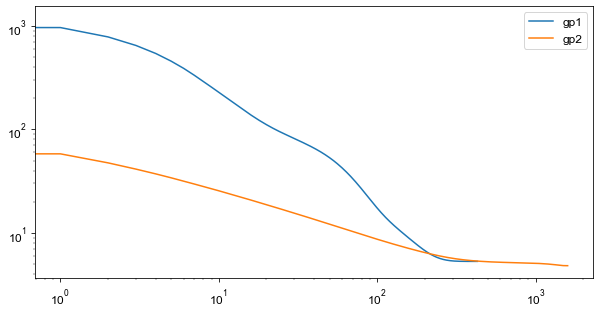

In [6]:
fig,ax = plt.subplots(1, figsize=(10,5))
ax.plot(gp1.losses_, label='gp1')
ax.plot(gp2.losses_, label='gp2')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

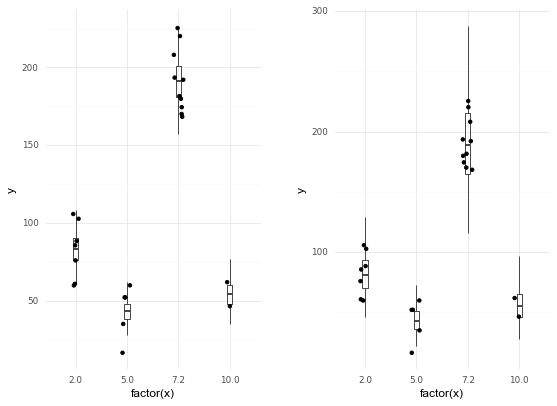

In [7]:
p1 = (
    ggplot(train_df, aes(x='factor(x)', y='y'))
    + geom_boxplot(aes(x='factor(x)', ymin='p1', lower='p25', middle='p50', upper='p75',
                       ymax='p99', group='x'),
                   data=test_df1, inherit_aes=False, alpha=0.5, stat='stat_identity', width=.1)
    + geom_jitter(width=.1)
    + theme_minimal()
)

p2 = (
    ggplot(train_df, aes(x='factor(x)', y='y'))
    + geom_boxplot(aes(x='factor(x)', ymin='p1', lower='p25', middle='p50', upper='p75',
                       ymax='p99', y='mean', group='x'),
                   data=test_df2, inherit_aes=False, alpha=0.5, stat='stat_identity', width=.1)
    + geom_jitter(width=.1)
    + theme_minimal()
)

p1 = pw.load_ggplot(p1, figsize=(3,5))
p2 = pw.load_ggplot(p2, figsize=(3,5))
p12 = (p1|p2)
p12.savefig()


In [15]:

gp = tx.GP('~ x', train_x_df, train_y_df, likelihood='poisson', kernel='rbf')
gp.fit(n_steps=5000, tol=1e-6, lr=0.3, debug=True)
optimized_lengthscale = gp.covar_module.base_kernel.lengthscale
optimized_lengthscale

Fitting GP:   6%|██████████                                                                                                                                                  | 322/5000 [00:00<00:08, 579.54it/s, loss=5.29]


tensor([[0.0375]], grad_fn=<SoftplusBackward0>)

In [16]:
# gp.covar_module.base_kernel.lengthscale = torch.tensor([.1])
test_x_df = pd.DataFrame(dict(x=np.arange(2,12,.1)))
percentiles = gp.predict(test_x_df)
train_df = pd.concat([train_x_df, train_y_df], axis=1)
test_df = pd.concat([test_x_df, percentiles], axis=1)

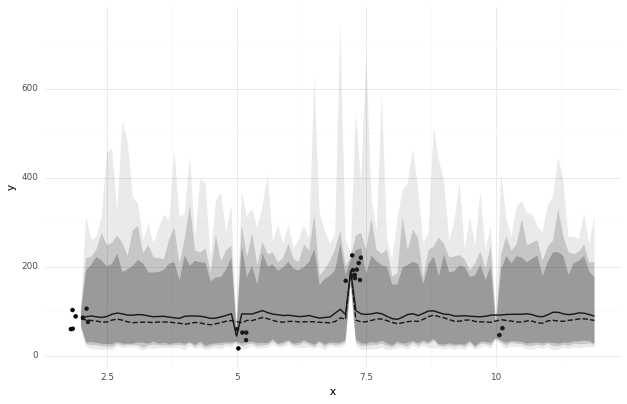

In [20]:
p = (
    ggplot(train_df, aes(x='x', y='y'))
    + geom_jitter(width=.2)
    + geom_smooth(aes(x='x', y='p50'), method='lowess', span=.05, linetype='dashed', alpha=.7, size=.8,
                 data=test_df, inherit_aes=False)
    + geom_smooth(aes(x='x', y='mean'), method='lowess', span=.05, alpha=.7, size=.8,
                 data=test_df, inherit_aes=False)
    + geom_ribbon(mapping=aes(x='x', ymin='p0.5', ymax='p99.5'), alpha=.1,
                 data=test_df, inherit_aes=False)
    + geom_ribbon(mapping=aes(x='x', ymin='p2.5', ymax='p97.5'), alpha=.2,
                 data=test_df, inherit_aes=False)
    + geom_ribbon(mapping=aes(x='x', ymin='p5', ymax='p95'), alpha=.3,
                 data=test_df, inherit_aes=False)
    + theme_minimal()
)

pw.load_ggplot(p, figsize=(8,5)).savefig()

In [9]:
dict(gp.covar_module.named_parameters())

{'raw_outputscale': Parameter containing:
 tensor(-0.4222, requires_grad=True),
 'base_kernel.raw_lengthscale': Parameter containing:
 tensor([[-5.8879]], requires_grad=True)}

In [10]:
dict(gp.likelihood.named_parameters())

{'alpha': Parameter containing:
 tensor([0.0665], requires_grad=True)}

In [21]:
import pandas as pd
import numpy as np

df = pd.read_csv('./docs/examples/salmon.merged.gene_counts.tsv', sep='\t', index_col=[0,1])
norm_df = tx.deseq_normalization(df)
norm_df

,,X02_CL,X02_LD,X05_CL,X05_LD,X08_CL,X08_LD,X11_CL,X11_LD,X14_CL,X14_LD,...,X35_CL,X35_LD,X38_CL,X38_LD,X41_CL,X41_LD,X44_CL,X44_LD,X47_CL,X47_LD
gene_id,gene_name,,,,,,,,,,,,,,,,,,,,,
AT1G01010,NAC001,390.293893,349.524048,388.666491,273.408022,309.093640,317.932202,267.178791,434.167596,256.892941,275.799858,...,386.689784,291.579265,288.363481,494.573598,317.088005,339.475567,304.036414,446.340484,317.325031,477.275322
AT1G01020,ARV1,208.070585,254.531449,173.741643,234.008613,199.622976,214.908875,238.708920,242.508027,205.727542,270.803484,...,160.103139,238.719866,163.440673,245.276337,170.834236,268.053435,210.670901,248.920654,142.389437,205.110056
AT1G01030,NGA3,149.914211,171.717389,126.123563,151.628030,96.591763,127.394436,86.504609,155.478936,99.132961,92.932561,...,85.478794,106.571369,66.625497,163.852635,90.947722,145.489529,122.093363,173.815285,109.843280,186.702743
AT1G01040,DCL1,1055.861293,1144.782595,1190.452002,1246.454040,1161.247635,1200.831035,1240.629387,860.512353,1137.364183,1047.240041,...,1375.801549,1139.034790,1216.956351,975.073964,1275.726162,982.274757,1554.894887,1173.789637,1282.861022,1217.512254
AT1G01046,MIR838A,0.000000,1.217854,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.998550,...,1.356806,0.000000,0.000000,0.000000,1.229023,1.763509,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATMG01370,ORF111D,1.292364,20.703515,1.286975,17.908822,2.146484,17.724443,2.189990,22.490664,0.000000,32.976070,...,4.070419,23.019416,4.164094,13.068002,0.000000,24.689132,0.000000,21.458677,6.780449,19.722121
ATMG01380,RRN5,0.000000,1.217854,0.000000,2.387843,0.000000,0.000000,0.000000,2.933565,0.000000,2.997825,...,0.000000,2.557713,1.041023,2.010462,0.000000,4.408774,0.000000,0.000000,0.000000,5.259232
ATMG01390,RRN18,2014.795295,5350.031852,2082.325772,5821.561206,2714.228529,5921.071845,2375.044254,4878.518327,2039.154341,5254.187153,...,1704.148664,6611.687725,1289.827989,6408.346929,1246.229603,5934.209258,1100.037260,5201.583329,1129.622866,5081.733113


Fitting GP:  10%|██████████████▋                                                                                                                                            | 1901/20000 [00:04<00:42, 429.74it/s, loss=673]


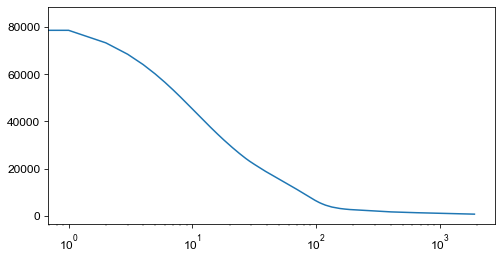

In [42]:
from plotnine import (
    ggplot, geom_point, geom_jitter, geom_line, geom_smooth, geom_ribbon, geom_rect, geom_boxplot,
    aes, facet_wrap, theme_bw, theme_void, theme_matplotlib, theme_linedraw, theme_minimal, theme_seaborn,
    theme, ylim, ggtitle, scale_y_continuous
)

covariates = pd.DataFrame(
    [[float(c[0]), 0.0 if c[1] == 'CL' else 1.0] for c in (c[1:].split('_') for c in df.columns)],
    columns=['time','treatment'],
    index=df.columns
)

expression = norm_df.loc['AT1G01010'].T
expression.columns = ['expression']
gp = tx.GP('~ time + treatment', covariates, expression, likelihood='gaussian', kernel='rbf')
gp.fit(n_steps=20000, lr=0.1, tol=1e-6)
fig,ax = plt.subplots(1, figsize=(8,4))
ax.plot(gp.losses_)
#ax.set_yscale('log')
ax.set_xscale('log')

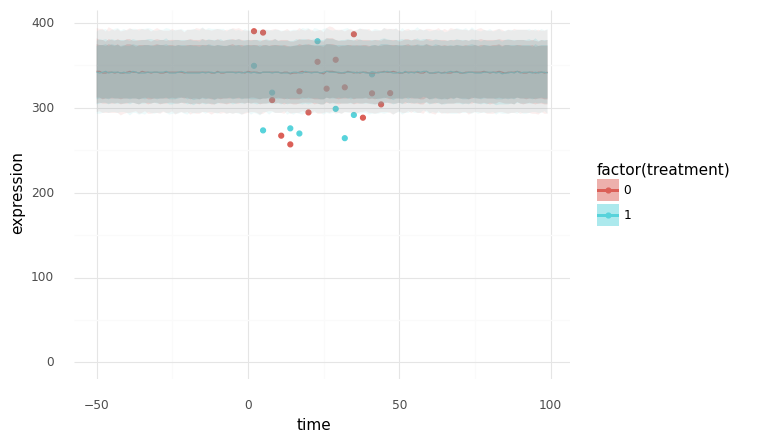

<ggplot: (381449897)>

In [41]:
x_range = range(-50,100)

test_x = pd.DataFrame(dict(
    time=list(x_range) * 2,
    treatment=[*[0]*len(x_range), *[1]*len(x_range)]
),dtype=np.float32)
percentiles = gp.predict(test_x)


train_df = pd.concat([covariates, expression], axis=1)
test_df = pd.concat([test_x, percentiles], axis=1)
(
    ggplot(train_df, aes(x='time', y='expression', group='treatment'))
    + geom_point(aes(color='factor(treatment)'))
    + geom_line(aes(x='time',y='p50', color='factor(treatment)'), data=test_df, inherit_aes=False, )
    + geom_ribbon(aes(x='time', ymin='p5', ymax='p95', fill='factor(treatment)'), alpha=.3, data=test_df, inherit_aes=False,)
    + geom_ribbon(aes(x='time', ymin='p2.5', ymax='p97.5', fill='factor(treatment)'), alpha=.2, data=test_df, inherit_aes=False,)
    + geom_ribbon(aes(x='time', ymin='p0.5', ymax='p99.5', fill='factor(treatment)'), alpha=.1, data=test_df, inherit_aes=False,)
    + scale_y_continuous(limits=(0, test_df.max().max()))
    + theme_minimal()
)

In [35]:
len(range(-25,75))

100

In [37]:
dict(gp.mean_module.named_parameters()),torch.log(torch.tensor(expression.mean()))

({'constant': Parameter containing:
  tensor([168.7028], requires_grad=True)},
 tensor([5.8346], dtype=torch.float64))

In [38]:
dict(gp.covar_module.named_parameters())

{'raw_outputscale': Parameter containing:
 tensor(425.5222, requires_grad=True),
 'base_kernel.raw_lengthscale': Parameter containing:
 tensor([[31.8021,  2.3545]], requires_grad=True)}

In [30]:
torch.max(torch.diff(gp.train_x, axis=0), axis=0).values

tensor([3., 1.])

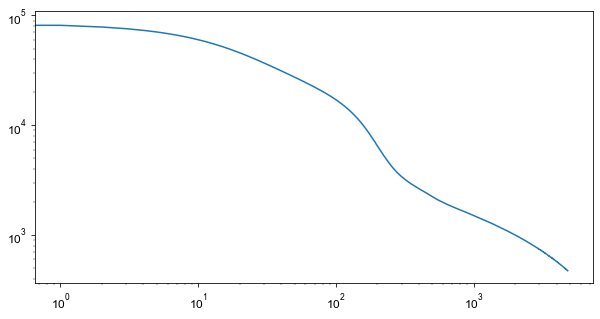

In [20]:
fig,ax = plt.subplots(1, figsize=(10,5))
ax.plot(gp.losses_)
ax.set_yscale('log')
ax.set_xscale('log')